# DS 2.1 Final Project
## Source: "Crime in Context, 1975-2015", Kaggle

Impact of rape and robbery rates on homicide rates

In [22]:
import math
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [11]:
ls

crime-rates.zip  report.csv*


In [12]:
df = pd.read_csv("report.csv")
df.head()

,report_year,agency_code,agency_jurisdiction,population,violent_crimes,homicides,rapes,assaults,robberies,months_reported,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
0,1975,NM00101,"Albuquerque, NM",286238.0,2383.0,30.0,181.0,1353.0,819.0,12.0,832.52,10.48,63.23,472.68,286.13
1,1975,TX22001,"Arlington, TX",112478.0,278.0,5.0,28.0,132.0,113.0,12.0,247.16,4.45,24.89,117.36,100.46
2,1975,GAAPD00,"Atlanta, GA",490584.0,8033.0,185.0,443.0,3518.0,3887.0,12.0,1637.44,37.71,90.30,717.10,792.32
3,1975,CO00101,"Aurora, CO",116656.0,611.0,7.0,44.0,389.0,171.0,12.0,523.76,6.00,37.72,333.46,146.58
4,1975,TX22701,"Austin, TX",300400.0,1215.0,33.0,190.0,463.0,529.0,12.0,404.46,10.99,63.25,154.13,176.10


In [13]:
df = df.drop(columns=['agency_code', 'violent_crimes', 'homicides', 'rapes', 'assaults', 'robberies', 'months_reported'])
df = df[df.agency_jurisdiction != 'Louisville, KY']
df = df[df.agency_jurisdiction != 'United States']
df.head()

,report_year,agency_jurisdiction,population,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
0,1975,"Albuquerque, NM",286238.0,832.52,10.48,63.23,472.68,286.13
1,1975,"Arlington, TX",112478.0,247.16,4.45,24.89,117.36,100.46
2,1975,"Atlanta, GA",490584.0,1637.44,37.71,90.30,717.10,792.32
3,1975,"Aurora, CO",116656.0,523.76,6.00,37.72,333.46,146.58
4,1975,"Austin, TX",300400.0,404.46,10.99,63.25,154.13,176.10


### Get dataframe with only Chicago, IL data

In [14]:
chi = df[df.agency_jurisdiction == 'Chicago, IL']
chi.head()

,report_year,agency_jurisdiction,population,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
10,1975,"Chicago, IL",3150000.0,1179.68,25.97,52.60,397.27,703.84
79,1976,"Chicago, IL",3134499.0,977.51,25.97,37.61,353.17,560.76
148,1977,"Chicago, IL",3086806.0,935.37,26.66,39.75,334.03,534.92
217,1978,"Chicago, IL",3086699.0,896.95,25.50,43.44,334.50,493.50
286,1979,"Chicago, IL",3060801.0,908.49,27.97,54.07,353.89,472.56


### Note: "per_capita" = per 100,000 residents

Let's get some visualizations cooking up in here

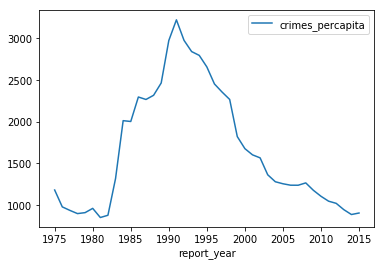

In [44]:
chi_by_year = chi.plot(x='report_year', y='crimes_percapita')

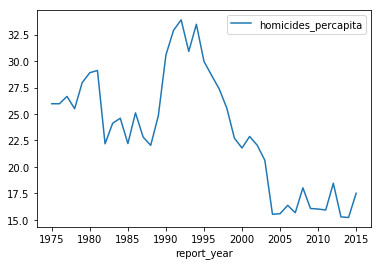

In [16]:
chi_by_year_hom = chi.plot(x='report_year', y='homicides_percapita')

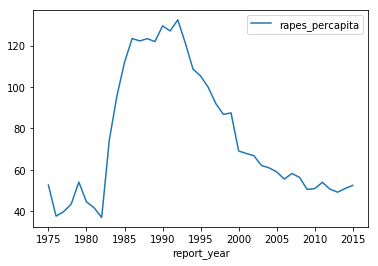

In [17]:
chi_by_year_rape = chi.plot(x='report_year', y='rapes_percapita')

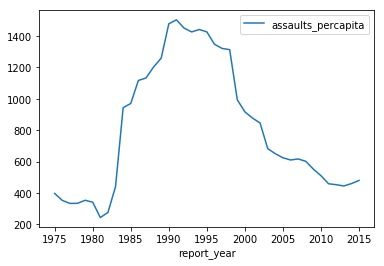

In [18]:
chi_by_year_assault = chi.plot(x='report_year', y='assaults_percapita')

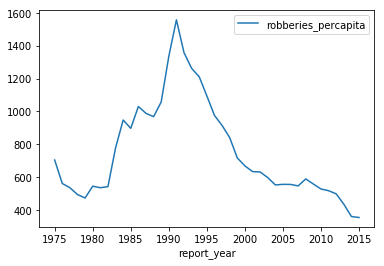

In [19]:
chi_by_year_rob = chi.plot(x='report_year', y='robberies_percapita')

### While I wanted to do data analysis on Chicago alone, this dataset sadly had less than 50 entries and I wanted to work with more data. So we'll look at data from the entire dataset with every city factoring in.

I want to examine the effect of certain crimes on the rate of homicides, as homicide is arguably the most devastating of the crimes tracked in this dataset. This issue aims to predict **continuous values**, so this is a job for **linear regression.**

Because these are all reported in terms of number of crimes per 100,000 city residents, there is no need for preprocessing. (Yay!)

### Drop the NA values that we can't work with

In [24]:
df = df.dropna()
df.count()

report_year            2740
agency_jurisdiction    2740
population             2740
crimes_percapita       2740
homicides_percapita    2740
rapes_percapita        2740
assaults_percapita     2740
robberies_percapita    2740
dtype: int64

Scramble the data so that the training and test parts aren't by default sorted by year.

In [29]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,report_year,agency_jurisdiction,population,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
0,2010,"Detroit, MI",713777.0,2377.91,43.43,56.46,1502.01,776.01
1,1998,"New Orleans, LA",471157.0,1461.93,48.82,63.46,720.35,629.30
2,2004,"Honolulu, HI",906589.0,276.53,2.87,24.49,158.95,90.23
3,2011,"Fresno, CA",500480.0,582.44,6.99,10.19,361.45,203.80
4,1987,"Austin, TX",469542.0,492.61,8.31,60.48,214.04,209.78


In [30]:
features = ['rapes_percapita', 'robberies_percapita']
X_train = df[features][:2050]
y_train = df['homicides_percapita'][:2050]
X_test = df[features][-690:]
y_test = df['homicides_percapita'][-690:]

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

print('For the first 75% of the dataset:')
print('     Weight of importance for rapes_percapita & robberies_percapita:')
print('          ' + str(model.coef_))
print('     Y-intercept:')
print('          ' + str(model.intercept_))

For the first 75% of the dataset:
     Weight of importance for rapes_percapita & robberies_percapita:
          [0.00829654 0.0272851 ]
     Y-intercept:
          2.301936055012968


In [33]:
predictions = model.predict(X_test)
reality = y_test.values
difference = predictions - reality

print('Predicted homicide rate using the linear representation obtained above:')
print(model.predict(X_test))
print('')

print('Actual homicide rate of last 690 entries:')
print(y_test.values)
print('')

print('The difference, positive or negative, between predicted rate and true rate:')
print(abs(difference))

Predicted homicide rate using the linear representation obtained above:
[ 8.73045723  7.32919365 15.07499016  9.96140159 27.7653481  14.31628369
 12.62310159 20.40012044 11.25326836 15.6626463  12.5006089  20.90349081
 19.78199656 25.51506783 16.77152114 25.02648805 25.84899903 15.69613865
 34.2485436  14.40902896  4.48269303 35.87496656 17.12828362  5.71194362
 11.43584139 19.58626062  6.2583141  10.30635373 35.82774764  5.30830811
 17.00146969 46.06927966 13.80924988  7.60856684 15.84102317  6.95734323
 13.77991869  9.67269896 10.22826811 10.07552527  7.46653936 14.11107805
 22.91636974 22.5189256  31.40374956  4.60423733  4.25652289 21.055119
 38.96443381  7.41454871  4.14394467 28.39117901  9.69528545 32.22619327
 31.64676113 19.41154193  5.98469591 21.78991023  7.98765741  5.01231439
 21.40728135 21.83321417 17.67406631  4.73997982  8.68877471 20.00222592
  9.8758199   4.18045178  6.80455013  7.99344571 10.74709001  9.7363083
 16.20402261  9.26920603 22.76476203  6.30466191  9.972

In [35]:
print('MSE: ' + str(mean_squared_error(reality, predictions)))
print('R2 score: ' + str(model.score(X_test, y_test)))
print('R2 score confirmed another way: ' + str(r2_score(y_test, model.predict(X_test))))

MSE: 66.56221856620624
R2 score: 0.5684230478438185
R2 score confirmed another way: 0.5684230478438185


### The R2 score of ~0.568 indicates a moderate effect size, meaning that the rate of rapes per capita and robberies per capita have a moderate effect on the rate of homicides per capita.

### Further investigation would include the timing of each of these crimes, as I specifically was curious if high amounts of rape and robbery CAUSE higher amounts of homicide. As we all know, correlation does not imply causation!!!

### The conclusions drawn here tell us that we can roughly predict the rate of homicides if given the rate of rape and robbery, but it doesn't tell us that the latter cause the former.